# Jacobi und Gauss-Seidel - Verfahren

## Jacobi-Verfahren

Analog zum [Richardson Verfahren](RichardsonVerfahren.ipynb) basiert das Verfahren auf der Fixpunkt Iteration. Ausgehend vom linearen Gleichungssystem

$$A\cdot x = b$$

wird die Matrix $A$ **additiv** zerlegt:

$$A = D-L-R$$

wobei $D$ die Diagonale, $L$ die untere Dreiecksmatrix **ohne** Diagonale und $R$ die obere Dreiecksmatrix **ohne** Diagonale von $A$ sei. Das Jacobi-Verfahren ist als Fixpunkt-Iteration gegeben durch

$$D\cdot x^{(k+1)} = (L+R)\cdot x^{(k)} + b.$$

Da $D$ diagonal ist, ist $D^{-1}$ einfach zu berechnen es folgt

$$x^{(k+1)} = D^{-1}\cdot((L+R)\cdot x^{(k)} + b),$$

wobei die Multiplikation mit der Diagonalmatrix nicht als Matrix-Multiplikatin umgesetzt wird. Eine elementweise Vektormultiplikation ist schneller.

Das Verfahren konvergiert, falls $2 D-A$ positiv definit ist.

## Gauss-Seidel Verfahren

Analog zum Jacobi-Verfahren gilt daher wiederum

$$A = D - L - R.$$

Im Fall des Gauss-Seidel-Verfahren ist die Fixpunktiteration gegeben durch

$$D\cdot x^{(k+1)} = b+L x^{\color{red}(\color{red}k\color{red}+\color{red}1\color{red})}+R x^{(k)}.$$

Der Unterschied ist daher, dass hier ausgenutzt wird, dass $L$ eine untere Dreiecksmatrix ohne Diagonale ist und daher $x^{k+1}$ sukzessive berechnet werden kann.

## Anwendung Jacobi Verfahren

Wir wenden das Verfahren auf das Modellproblem

$$\begin{split}
-\Delta u + 10\, u & = 1\quad x\in\Omega = [0,1]^2\\
u & = 0\quad x \in \partial\Omega\end{split}$$

an.

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
from myst_nb import glue

Diskretierung der schwachen Gleichung mit FEM 1. Ordnung:

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=1, dirichlet='bottom|right|top|left')
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)

Wir nutzen das CSR Modul von `scipy` um das reduzierte Problem für die freien Freiheitsgrade zu lösen.

In [3]:
import scipy.sparse as sp
import numpy as np
from numpy.linalg import norm

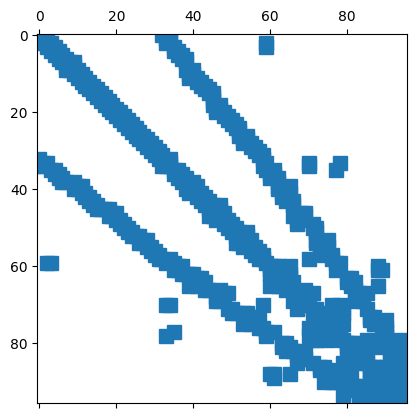

In [4]:
rows,cols,vals = a.mat.COO()
ind = np.arange(fes.ndof)[np.array(fes.FreeDofs())]

# Reduktion auf die freien Freiheitsgrade der Systemmatrix
A = sp.csr_matrix((vals,(rows,cols)))
A = A[np.ix_(ind,ind)]
plt.spy(A)
plt.show()

# Reduktion auf die freien Freiheitsgrade der rechten Seite
fd = np.array(f.vec)[ind]

In [5]:
alpha = 1
d = A.diagonal()
L = -sp.tril(A,-1)
R = -sp.triu(A,1)
LR = L+R

In [6]:
sol = np.zeros(fes.ndof)
err0 = Norm(f.vec)
its = 0
errs = []
while True:
    sol[ind] = LR @ sol[ind]+fd
    sol[ind] /= d
    err = norm(A@sol[ind]-fd)
    errs.append(err)
    #print ("iteration", its, "res=", err)
    if err < 1e-8 * err0 or its > 10000: break
    its = its+1
print ("needed", its, "iterations")

needed 242 iterations


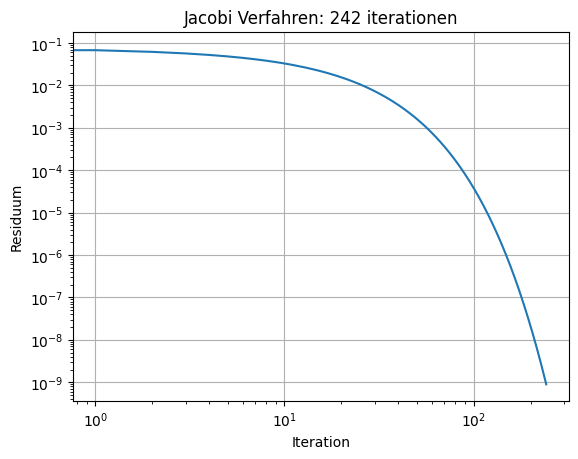

In [8]:
fig, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('Jacobi Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
#plt.savefig('FEM_JacobiVerfahren_fig.png')
glue("FEM_JacobiVerfahren_fig", fig, display=False)

In [9]:
gfu.vec[:] = sol
Draw(gfu,mesh,'u');

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

## Anwendung Gauss-Seidel Verfahren

In jedem Iterationsschritt wird das Gleichungssystem mit Hilfe von Rückwärtseinsetzen gelöst

$$\underbrace{(D-L)}_{=:C}\cdot x^{(k+1)} = b+R x^{(k)}.$$

In [10]:
from scipy.sparse.linalg import spsolve_triangular

In [11]:
C = sp.tril(A,format='csr')

In [12]:
sol = np.zeros(fes.ndof)
err0 = Norm(f.vec)
its = 0
errs = []
while True:
    r = R@sol[ind]+fd
    sol[ind] = spsolve_triangular(C,r)
    err = norm(A@sol[ind]-fd)
    errs.append(err)
    #print ("iteration", its, "res=", err)
    if err < 1e-8 * err0 or its > 10000: break
    its = its+1
print ("needed", its, "iterations")

needed 123 iterations


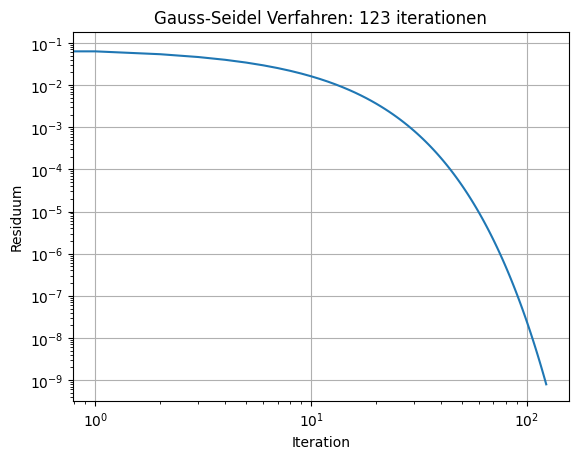

In [14]:
fig2, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('Gauss-Seidel Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
#plt.savefig('FEM_Gauss-SeidelVerfahren_fig.png')
glue("FEM_Gauss-SeidelVerfahren_fig", fig2, display=False)

In [15]:
gfu.vec[:] = sol
Draw(gfu,mesh,'u');

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…